# Código - Prototipação de um Sistema de Segurança Veicular para Alertas Contra o Sono e Cansaço Via reconhecimento de Imagens
por Almerindo Abreu, 
Raphael Marques, <br>
Orientador: Irineu Neto

# Sumário
1. [Aquisição de dados do cojunto de dados](#Aquisi%C3%A7%C3%A3o-de-dados-do-cojunto-de-dados---Amostragem-inicial)<br>
    1.1. [Razão de Aspecto](#Raz%C3%A3o-de-Aspecto)<br>
    1.2. [Desvio Padrão](#Desvio-Padr%C3%A3o)<br>
    1.3. [Erro Padrão](#Erro-Padr%C3%A3o)<br>
2. [Calibramgem do gráfico de abertura dos olhos](#Calibramgem-do-gr%C3%A1fico-de-abertura-dos-olhos)<br>
    2.1. [Calibragem do cojunto de dados da abertur dos olhos](#Calibragem-do-cojunto-de-dados-da-abertur-dos-olhos)<br>
    2.2. [Conversão do cojunto dados em porcentagem](#Convers%C3%A3o-do-cojunto-dados-em-porcentagem)<br>
3. [Execução e análise dos dados obtidos pela aquisição de imagem](#Execu%C3%A7%C3%A3o-e-an%C3%A1lise-dos-dados-obtidos-pela-aquisi%C3%A7%C3%A3o-de-imagem)<br>
    3.1. [Gráfico analítico](#Gr%C3%A1fico-anal%C3%ADtico)<br>
    3.2. [Porcentagem de abertura dos olhos](#Porcentagem-de-abertura-dos-olhos)<br>
    3.3. [Janela de Avaliação PERCLOS](#Janela-de-avalia%C3%A7%C3%A3o-PERCLOS)
4. [Classe principal](#Classe-principal)<br>
    4.1. [Aquisição da amostra de dados](#Aquisi%C3%A7%C3%A3o-da-amostra-de-dados)<br>
    4.1.1. [Análise do gráfico gerado a apartir dos dados obtidos](#An%C3%A1lise-do-gr%C3%A1fico-gerado-a-apartir-dos-dados-obtidos)<br>
    4.2. [Calibragem dos dados aquisitados](#Calibragem-dos-dados-aquisitados)<br>
    4.2.1. [Análise dos dados não calibrados e calibrados com o threshold do P80](#An%C3%A1lise-dos-dados-n%C3%A3o-calibrados-e-calibrados-com-o-threshold-do-P80)<br>
    4.3. [Execução e análise em tempo real](#Execu%C3%A7%C3%A3o-e-an%C3%A1lise-em-tempo-real)<br>

In [1]:
%config InlineBackend.rc={'figure.figsize': (14, 6)}
%matplotlib inline
from matplotlib import pyplot as plt
import winsound
import cv2
import math
import numpy as np
from imutils import face_utils
from scipy.spatial import distance

import dlib
from skimage import io
from primesense import openni2

## Aquisição de dados do cojunto de dados - Amostragem inicial

### Razão de Aspecto

A Razão de Aspecto (RA) tem como objetivo medir a relação entre as dimensões de altura e largura de uma figura. No contexto desse projeto de protopação, a razão de aspecto representa a referência da abertura dos olhos medindo a razão da distância vertical das extremidades sobre a distância das extremidades horizontais do olho.

<img src="http://i63.tinypic.com/2s8myky.png">

A função <code>razaoDeAspecto()</code> é baseada nos pontos do LandMark Points que são pontos de referências comuns em faces humanas, dos quais são relacionados numericamente conforme a Figura 1. Como a estrutura de matriz inicia com indice 0, a relação do código é sempre menos 1 com relação do demonstrado abaixo.

<img src="http://i63.tinypic.com/bio66h.jpg" height="800" width="400">
<center> Figura 1 - Cada ponto dos 68 existentes na coordenada dos landmark points. Fonte: iBUG 300-W dataset </center>

Com o objetivo ter um resultado menos variavel com realação à movimentos do sujeito (motorista), o calculo é obtido com a média dos resultados dos dois olhos, isso faz com seja previnidos resultados indevidos caso tenha falha de reconhecimento de algum dos olhos, quando o sujeito movimente o rosto demasiadamente para o lado impossibilitando a aquisição ideal, por exemplo.

<img src="http://i65.tinypic.com/35ji6g7.png">
<center> Figura 2 - Razão de Aspecto com as devidas variáveis da função razaoDeAspecto()</center>

In [2]:
#Calculando a Razão de Aspecto
def razaoDeAspecto(shape):
    
    #RAD = RAZÃO DE ASPECTO DIREITA
    distVerticalDir = distance.euclidean((shape[43] + shape[44]) // 2, (shape[47] + shape[46]) // 2) 
    distHorizontalDir = distance.euclidean(shape[42], shape[45])
    rad = distVerticalDir / distHorizontalDir
    
    #RAE = RAZÃO DE ASPECTO ESQUERDA
    distVerticalEsq = distance.euclidean((shape[37] + shape[38]) // 2, (shape[41] + shape[40]) // 2) 
    distHorizontalEsq = distance.euclidean(shape[36], shape[39])
    rae = distVerticalEsq / distHorizontalEsq
   
    ra = (rad + rae) / 2

    return ra### Razão de Aspecto

### Desvio Padrão

O desvio padrão é uma medida de dispersão utilizada para analisar o quão os dados de uma série é disperso com relação a média desse cojunto de dados, sendo este valor obtido (que é chamado de variância) radiciado resultado no desvio padrão desse conjunto de dados.

<img src="http://oi65.tinypic.com/2zyzhvl.jpg" height="250" width="300">

A função <code>desvioPadrao()</code> comporto por 3 partes a primeira o calculo da média do cojunto, a segunda o calculo da variância e a terceira parte é a raiz quadrada do valor obtido na variância.

In [3]:
#Calcular desvio padrão
def desvioPadrao(x):
    variancia, media = 0, 0
    global matrizRA
    count = 0
    
    #Calculo da média
    for i in range(x + 1):
        media += matrizRA[0][i]
        count += 1
    media = media / count

    #Calculo da variância
    for j in range(x + 1):
        variancia = variancia + math.pow((matrizRA[0][j] - media), 2)
    variancia = variancia / count

    #Raiz quadrada da variância
    devPadrao = math.sqrt(variancia)
    return devPadrao

### Erro Padrão

O erro padrão é uma medida de variação de uma média amostral em relação à média da população. Sendo assim, é uma medida que ajuda a verificar a confiabilidade da média amostral calculada.

<img src="http://i64.tinypic.com/24ywb5f.png" height="250" width="300">

In [4]:
#Calcular erro padrão
def erroPadrao(x):
    global matrizRA
    if x > 0:
        erroPad = matrizRA[1][x] / math.sqrt(x)
    else:
        erroPad = 0
    return erroPad

## Calibramgem do gráfico de abertura dos olhos

### Calibragem do cojunto de dados da abertur dos olhos

A função de calibrangem <code>calibragemAberturaOlhos()</code> consiste em coletar um conjunto de dados obtidos pela aquisição da câmera, e a partir desse conjunto de dados minimizar os possíveis erros que possam prejudicar a referência de 100% e 0% do razão de aspecto baseado em diminuir o valor máximo da razão de aspecto pelo erro padrão desse valor e adicionar o valor de erro padrão no valor mínimo da razão de aspecto do menor valor desse conjunto de dados.

In [5]:
def calibragemAberturaOlhos():
    global matrizRA
    valorMaxOlho, valorMinOlho, flagValorMax, flagValorMin = 0, 0, 0, 0
    for x in range(197):
        if valorMaxOlho < matrizRA[0][x]:
            valorMaxOlho = matrizRA[0][x]
            flagValorMax = x

        if (valorMinOlho > matrizRA[0][x]) or (valorMinOlho == 0):
            valorMinOlho = matrizRA[0][x]
            flagValorMin = x

    matrizRA[0][flagValorMax] = matrizRA[0][flagValorMax] - matrizRA[2][flagValorMax]
    matrizRA[0][flagValorMin] = matrizRA[0][flagValorMin] + matrizRA[2][flagValorMin]

    #print("Valor Máximo " + str(flagValorMax) + ": "+ str(valorMaxOlho) + "\n")
    #print("Valor Mínimo " + str(flagValorMin) + ": "+ str(valorMinOlho) + "\n")

### Conversão do cojunto dados em porcentagem

A função de conversão <code>converterParaPorcentagem()</code> do cojunto é responsável por converter os valores obtido pela razão de aspecto dos olhos em porcentagem, sendo o valor máximo desse cojunto menos o erro padrão o 100% e o valor mínimo mais o erro padrão desse valor sendo o 0%. Baseado nesse valor que é determinado os 80% referente ao PERCLOS 80.

In [6]:
def converterParaPorcentagem():
    global matrizRA
    matrizAnalitica = []
    aberturaMin = matrizRA[0].min()
    aberturaMax = matrizRA[0].max()
    for i in range(len(matrizRA[0])):
        #Calcular a porcentagem
        porcentagem = (matrizRA[0][i] - aberturaMin) / (aberturaMax - aberturaMin) * 100
        matrizAnalitica.append(porcentagem)
    return matrizAnalitica

## Execução e análise dos dados obtidos pela aquisição de imagem

### Gráfico analítico

A determinação do gráfico analítico tem como função plotar o gráfico a partir dos dados coletados e calibrados, sendo essa a parametrização e a partir dessa conclusão as próximas aquisições serão analisadas. 

In [7]:
def graficoAnalitico(fig, ax, shape):
    global matrizRA
    global matrizAnalitica
    global p80_porcento
    global indiceDeBaixoPerclos

    eixoXinicio = len(matrizAnalitica) - len(matrizRA[0])
    eixoXfinal = len(matrizAnalitica)

    matrizAnalitica = porcentagemAberturaDosOlhos(matrizAnalitica, razaoDeAspecto(shape))
    indiceDeBaixoPerclos = janelaDeAvaliacaoPerclos(matrizAnalitica[-1], indiceDeBaixoPerclos)
    p80_porcento.append(80)
    
    ax.clear()
    ax.axis([len(matrizAnalitica) - len(matrizRA[0]), eixoXfinal, 0, 100])
    ax.plot(p80_porcento, 'r--')
    ax.plot(matrizAnalitica[0:len(matrizAnalitica)], 'b',)
    ax.plot(matrizAnalitica[0:len(matrizAnalitica)], 'o', markersize=3)
    plt.title("Análise - Segurança Veicular")
    fig.canvas.draw()
    

### Porcentagem de abertura dos olhos

A função <code>porcentagemAberturaDosOlhos()</code> é responsável para conversão da razão de aspceto em porcentagem no decorrer das aquisições dos frames.

In [8]:
def porcentagemAberturaDosOlhos(matrizAnalitica, RA):
    global matrizRA
    aberturaMin = matrizRA[0].min()
    aberturaMax = matrizRA[0].max()
    
    #Calcular a porcentagem
    porcentagem = (RA - aberturaMin) / (aberturaMax - aberturaMin) * 100
    matrizAnalitica.append(porcentagem)
    return matrizAnalitica

### Janela de avaliação PERCLOS

A janela de avaliação PERCLOS é responsável por definir a quantidade de frames estão sequencialmente abaixo do threshold do P80 e sendo essa sequencia de valores baixos serão responsáveis por alarmar o sinal sonoro para sinalizar o motorista.

In [9]:
def janelaDeAvaliacaoPerclos(porcentagem, indiceDeBaixoPerclos):
    if (porcentagem <= 80):
        indiceDeBaixoPerclos = indiceDeBaixoPerclos + 1
    else:
        indiceDeBaixoPerclos = 0
        
    if (indiceDeBaixoPerclos > 20):
        frequencia = 2500  # 2500 Hz
        duracao = 1000  # 1 segundo
        winsound.Beep(frequencia, duracao)
    return indiceDeBaixoPerclos

## Classe principal

In [10]:
#Funções de predição de dados
arq_predicao = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predicao = dlib.shape_predictor(arq_predicao)

### Aquisição da amostra de dados

In [11]:
matrizShape = []
eixoX = []
matrizRA = np.zeros((3, 197))
qtdImg = 0
while(qtdImg < 197):
    eixoX.append(qtdImg)
    img = cv2.imread("TESTE 4/IMG-"+ str(qtdImg +1) +".png")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    for (i, rect) in enumerate(rects):
        shape = predicao(gray, rect)
        # Transforma os valores predicados do rosto para um array NumPy
        shape = face_utils.shape_to_np(shape)
        
        matrizRA[0][qtdImg] = razaoDeAspecto(shape)
        matrizRA[1][qtdImg] = desvioPadrao(qtdImg)
        matrizRA[2][qtdImg] = erroPadrao(qtdImg)
    #    print("Valor de " + str(qtdImg) + 
    #           " -> RA: " + str(matrizRA[0][qtdImg]) + 
    #           " -> Desv. Pad: " + str(matrizRA[1][qtdImg]) +
    #          " -> Erro Pad: " + str(matrizRA[2][qtdImg])) 

    #cv2.circle(img, (((shape[43][0] + shape[44][0])//2), ((shape[43][1] + shape[44][1])//2)), 3, (0, 0, 255), -1)
    matrizShape.append(razaoDeAspecto(shape))
    qtdImg += 1

#### Análise do gráfico gerado a apartir dos dados obtidos

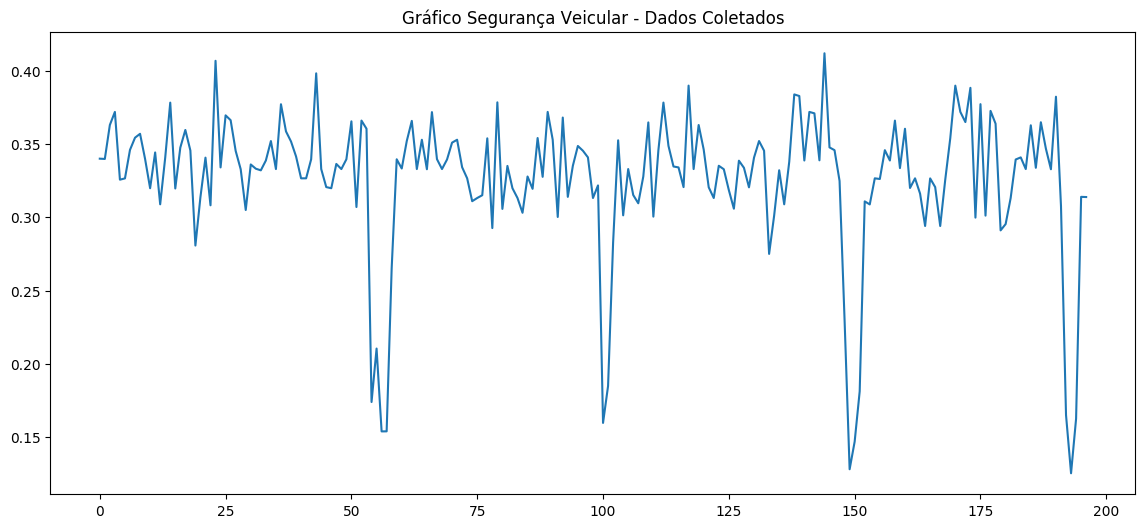

In [12]:
plt.plot(matrizShape)
plt.title("Gráfico Segurança Veicular - Dados Coletados")
plt.show()

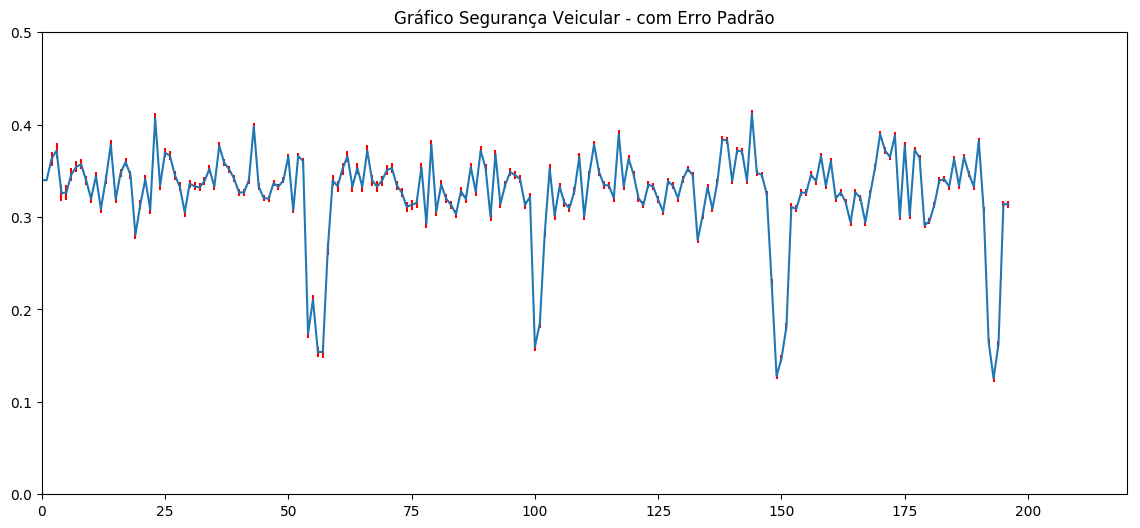

In [13]:
eixoX = np.array(eixoX)
matrizShape = np.array(matrizShape)

plt.errorbar(eixoX, matrizShape, yerr=matrizRA[2], ecolor='r')
plt.axis([0, 220, 0, 0.5])

plt.title("Gráfico Segurança Veicular - com Erro Padrão")
plt.show()

### Calibragem dos dados aquisitados 

#### Análise dos dados não calibrados e calibrados com o threshold do P80

In [14]:
print("MIN: " + str(matrizRA[0].min()) + " MAX: " +str(matrizRA[0].max()))

MIN: 0.12537204504606136 MAX: 0.41200828808388845


In [15]:
calibragemAberturaOlhos()
matrizAnalitica = converterParaPorcentagem()

print("MIN: " + str(matrizRA[0].min()) + " MAX: " +str(matrizRA[0].max()))

MIN: 0.12811979291695885 MAX: 0.40857354832968396


In [16]:
#Criar uma matriz com os valores de 80% para ser indicado no gráfico
aux = ((matrizRA[0].max() - matrizRA[0].min()) * 0.80) + matrizRA[0].min()
P80 = np.zeros(197)
for i in range(len(P80)):
    P80[i] = aux

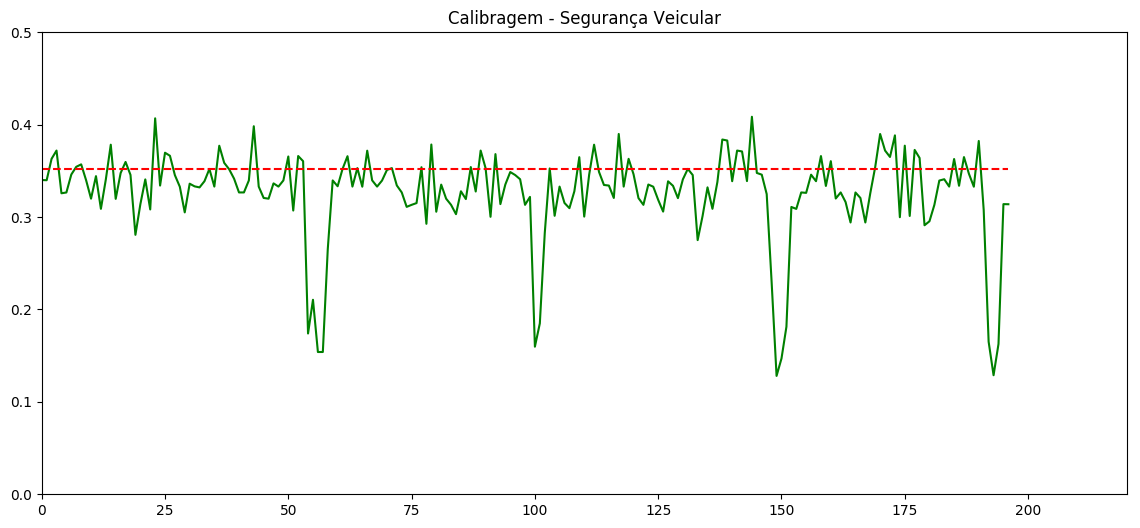

In [17]:
#Plotar o cojunto de dados de amostragem
plt.plot(eixoX, matrizRA[0], 'g')
plt.plot(eixoX, P80, 'r--')
plt.axis([0, 220, 0, 0.5])
plt.title("Calibragem - Segurança Veicular")
plt.show()

### Execução e análise em tempo real

<IPython.core.display.Javascript object>


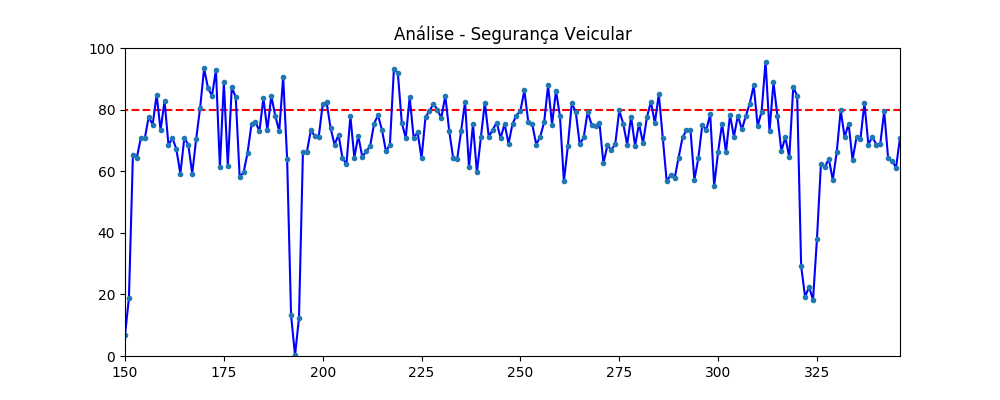

<IPython.core.display.Javascript object>


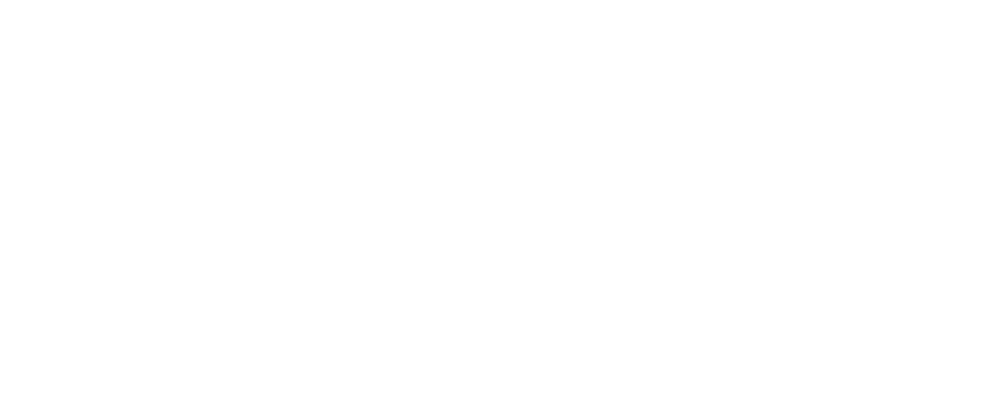

In [18]:
%matplotlib notebook
#matrizAnalitica = converterParaPorcentagem()

figGrafico = plt.figure(figsize=(10, 4))
ax = figGrafico.add_subplot(111)
plt.ion()

figGrafico.show()
figGrafico.canvas.draw()

indiceDeBaixoPerclos = 0

p80_porcento = []
for i in range(len(matrizAnalitica)):
    p80_porcento.append(80)


for contImg in range(0,150):
    img = cv2.imread("TESTE 1/IMG-"+ str(contImg +1) +".png")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    for (i, rect) in enumerate(rects):
        shape = predicao(gray, rect)
        shape = face_utils.shape_to_np(shape)
    
    contImg += 1
        
    graficoAnalitico(figGrafico, ax, shape)